# New Section

In [ ]:
# from google.colab import drive
# drive.mount('/content/MyDrive')

# LOCAL VERSION

Step 0: Content Loss: 0.0, Style Loss: 1395342592.0
Step 100: Content Loss: 24.6174259185791, Style Loss: 21184384.0
Step 200: Content Loss: 27.13550567626953, Style Loss: 14608520.0
Step 300: Content Loss: 28.53581428527832, Style Loss: 11567608.0
Step 400: Content Loss: 29.46940803527832, Style Loss: 9506818.0


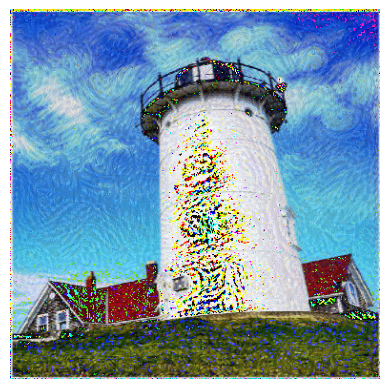

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
# import copy

# Load images
def load_image(image_path, transform_=None, max_size=400):
    image = Image.open(image_path).convert("RGB")
    size = max_size if max(image.size) > max_size else max(image.size)
    transform = transform_
    if transform_ is None:
        transform = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor(),
        ])

    image = transform(image).unsqueeze(0)
    return image

# Display image
def show_image(tensor):
    image = tensor.clone().detach().squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Load VGG-19 model
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        # self.model = models.vgg19(pretrained=True).features[:21] # Extract layers up to relu4_2
        self.model = models.vgg19(pretrained=True).features[:22] # Include the conv4_2 layer
        for param in self.model.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = {}
        layers = {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1', '21': 'conv4_2'}
        # for name, layer in self.model._modules.items():
        for name, layer in self.model.named_children():  # Correct way to iterate layers
            x = layer(x)
            if name in layers:
                features[layers[name]] = x
        return features

# Compute content loss
def content_loss(target_features, generated_features):
    return torch.mean((target_features - generated_features) ** 2)

# Compute style loss
def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    return torch.mm(tensor, tensor.t())

def style_loss(target_features, generated_features):
    loss = 0
    for layer in target_features:
        gram_target = gram_matrix(target_features[layer])
        gram_generated = gram_matrix(generated_features[layer])
        loss += torch.mean((gram_generated - gram_target) ** 2)
    return loss

# Run style transfer
def style_transfer(content_path, style_path, num_steps=500, style_weight=1e6, content_weight=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = transforms.Compose([transforms.ToTensor()])

    content = load_image(content_path).to(device)
    style = load_image(style_path).to(device)
    generated = content.clone().requires_grad_(True).to(device)

    model = VGG().to(device).eval()


    adam_optimizer = optim.Adam([generated], lr=0.003)
    optimizer = adam_optimizer
    for step in range(num_steps):
        optimizer.zero_grad()
        content_features = model(content)
        style_features = model(style)
        generated_features = model(generated)
        c_loss = content_loss(content_features['conv4_2'], generated_features['conv4_2'])
        s_loss = style_loss(style_features, generated_features)

        total_loss = content_weight * c_loss + style_weight * s_loss
        total_loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print(f"Step {step}: Content Loss: {c_loss.item()}, Style Loss: {s_loss.item()}")

    show_image(generated.cpu())
    return generated


# Example usage
content_image_path_ = r"/content/drive/MyDrive/Colab Notebooks/MY_PROJECT/IMAZE/content.png"
style_image_path_ = r"/content/drive/MyDrive/Colab Notebooks/MY_PROJECT/IMAZE/style.png"
styled_image = style_transfer(content_path=content_image_path_, style_path=style_image_path_)


In [6]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# ==================================
# 1. Load and Preprocess Images
# ==================================
def load_image(image_path, image_size):
    """Loads an image, resizes it, and converts to tensor."""
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set image size
image_size = (512, 512)  # Change for larger images

# Content Image Path
content_img_path = r"/content/drive/MyDrive/Colab Notebooks/MY_PROJECT/IMAZE/content.png"
style_img_path = r"/content/drive/MyDrive/Colab Notebooks/MY_PROJECT/IMAZE/style.png"

# Load images
content_img = load_image(content_img_path, image_size).to(device)
style_img = load_image(style_img_path, image_size).to(device)

# ==================================
# 2. Define VGG-19 Model
# ==================================
vgg = models.vgg19(pretrained=True).features.to(device).eval()

# Define feature layers for content and style
vgg_layer_map = {
    "conv1_1": 0, "conv2_1": 5, "conv3_1": 10,
    "conv4_1": 19, "conv4_2": 21, "conv5_1": 28
}

content_feature_layer = "conv4_2"
style_feature_layers = ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]  # ✅ Full style transfer

content_feature_layer_idx = vgg_layer_map[content_feature_layer]
style_feature_layer_idxs = [vgg_layer_map[layer] for layer in style_feature_layers]

# ==================================
# 3. Extract Features
# ==================================
def get_features(image, model, layers):
    """Extracts features from VGG-19 for specified layers."""
    features = {}
    x = image
    for name, layer in model.named_children():
        x = layer(x)
        if int(name) in layers:
            features[name] = x
    return features

# Extract content and style features
content_features = get_features(content_img, vgg, [content_feature_layer_idx])
style_features = get_features(style_img, vgg, style_feature_layer_idxs)

# ==================================
# 4. Define Loss Functions
# ==================================
def gram_matrix(tensor):
    """Computes the Gram matrix for style representation."""
    B, C, H, W = tensor.size()
    tensor = tensor.view(C, H * W)
    gram = torch.mm(tensor, tensor.t())
    return gram / (C * H * W)

def compute_losses(dl_transfer, content_features, style_features, alpha, beta):
    """Computes content and style loss."""
    transfer_features = get_features(dl_transfer, vgg, [content_feature_layer_idx])
    transfer_style_features = get_features(dl_transfer, vgg, style_feature_layer_idxs)

    # Compute content loss (preserves structure)
    content_loss = F.mse_loss(
        transfer_features[str(content_feature_layer_idx)],
        content_features[str(content_feature_layer_idx)]
    )

    # Compute style loss (captures brush strokes & textures)
    style_loss = 0
    for layer_idx in style_feature_layer_idxs:
        transfer_gram = gram_matrix(transfer_style_features[str(layer_idx)])
        style_gram = gram_matrix(style_features[str(layer_idx)])
        style_loss += F.mse_loss(transfer_gram, style_gram)

    total_loss = alpha * content_loss + beta * style_loss
    return content_loss, style_loss, total_loss

# ==================================
# 5. Initialize Transfer Image
# ==================================
transfer_img = content_img.clone().requires_grad_()

# ==================================
# 6. Training Loop
# ==================================
alpha = 1.0  # Content weight
beta = 1e5   # Style (texture) weight - increase for more stylization
num_iterations = 3000
learning_rate = 3.0

# Adam optimizer
optimizer = optim.Adam([transfer_img], lr=learning_rate)

# Track minimum loss
min_loss = float('inf')
best_transfer_image = None

# Training loop
for iteration in range(1, num_iterations + 1):

    # Compute losses
    optimizer.zero_grad()
    loss_content, loss_style, total_loss = compute_losses(transfer_img, content_features, style_features, alpha, beta)

    # Backpropagate and update image
    total_loss.backward(retain_graph=True) # Add retain_graph=True here
    optimizer.step()

    # Save the best image (lowest loss)
    if total_loss.item() < min_loss:
        min_loss = total_loss.item()
        best_transfer_image = transfer_img.clone()

    # Display the stylized image every 100 iterations
    if iteration == 1 or iteration % 100 == 0:
        with torch.no_grad():
            transfer_image_np = transfer_img.squeeze().cpu().detach().numpy()
            transfer_image_np = transfer_image_np.transpose(1, 2, 0)  # Convert (C, H, W) to (H, W, C)
            transfer_image_np = transfer_image_np.clip(0, 1)  # Normalize

            plt.imshow(transfer_image_np)
            plt.title(f"Style Transfer After {iteration} Iterations")
            plt.axis("off")
            plt.show()

# ==================================
# 7. Save Final Image
# ==================================
final_image = best_transfer_image.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
final_image = final_image.clip(0, 1)

plt.figure()
plt.imshow(final_image)
plt.title("Final Stylized Image")
plt.axis("off")
plt.show()
plt.savefig(r'/content/drive/MyDrive/Colab Notebooks/MY_PROJECT/IMAZE/final_image.png')


Output hidden; open in https://colab.research.google.com to view.